In [1]:
# Importação de módulos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Importando classificadores

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report


In [2]:
# importando os dados e visualizando as 5 primeiras linhas

df = pd.read_csv("cardio_train.csv", sep = ";"); df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [3]:
# Conferindo os tipos de dados, possíveis dados faltantes e mais alguns aspectos do nosso conjunto de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
# renomeando as colunas para uma compreensão mais rápida na análise

df.columns = ["id", "idade", "genero", "altura", "peso", "pressao_sist", "pressao_diast", "colesterol", "glicose", "fumante", "ing_alcool", "atividade_fis", "cardio"]
df.head()

,id,idade,genero,altura,peso,pressao_sist,pressao_diast,colesterol,glicose,fumante,ing_alcool,atividade_fis,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
# Como a coluna 'id' não terá serventia, iremos exclui-la

df.drop('id', axis = 1, inplace = True)

In [6]:
# Vamos verificar a existência de possíveis dados duplicados

df.duplicated().sum()

24

In [7]:
# Dando uma olhada nas duplicadas antes de exclui-las
duplicadas = df[df.duplicated(keep = False)]

In [8]:
# Vamos ordená-las para ficar mais fácil de enxergar os valores duplicados
duplicadas.sort_values(by = 'idade').head(10)

,idade,genero,altura,peso,pressao_sist,pressao_diast,colesterol,glicose,fumante,ing_alcool,atividade_fis,cardio
40365,14552,1,158,64.0,120,80,1,1,0,0,1,0
6325,14552,1,158,64.0,120,80,1,1,0,0,1,0
64169,16160,1,168,65.0,120,80,1,1,0,0,1,1
17101,16160,1,168,65.0,120,80,1,1,0,0,1,1
1204,16793,1,165,68.0,120,80,1,1,0,0,1,0
21784,16793,1,165,68.0,120,80,1,1,0,0,1,0
28300,16805,1,157,67.0,120,80,1,1,0,0,1,0
60474,16805,1,157,67.0,120,80,1,1,0,0,1,0
44653,16937,2,170,70.0,120,80,1,1,0,0,0,0
10494,16937,2,170,70.0,120,80,1,1,0,0,0,0


In [9]:
# Excluindo os valores duplicados do nosso conjunto de dados e verificando se teremos ainda algum valor duplicado.

df.drop_duplicates(inplace = True)
df.duplicated().sum()

0

In [10]:
# Como podemos conferir no dicionário de dados, a coluna idade está calculada em dias e isso torna a análise pouco intuitiva.
# Vamos ainda transformar a coluna altura(em cm) para Metros. Nenhum desses passos é obrigatório, mas facilita a análise.
# Além disso precisaremos da altura em metros quando formos criar uma coluna com o IMC.
# Vamos passar para anos a idade e para metros a altura.

df.idade = (df.idade / 365).round().astype('int')
df.altura = df.altura / 100
df.head()

,idade,genero,altura,peso,pressao_sist,pressao_diast,colesterol,glicose,fumante,ing_alcool,atividade_fis,cardio
0,50,2,1.68,62.0,110,80,1,1,0,0,1,0
1,55,1,1.56,85.0,140,90,3,1,0,0,1,1
2,52,1,1.65,64.0,130,70,3,1,0,0,0,1
3,48,2,1.69,82.0,150,100,1,1,0,0,1,1
4,48,1,1.56,56.0,100,60,1,1,0,0,0,0


In [11]:
# Verificando a existência de valores faltantes(miss values) no nosso df

df.isnull().sum().any()

False

# Análise Exploratória

In [12]:
df.describe()

,idade,genero,altura,peso,pressao_sist,pressao_diast,colesterol,glicose,fumante,ing_alcool,atividade_fis,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,53.338945,1.349648,1.643592,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,6.765633,0.476862,0.082112,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,30.000000,1.000000,0.550000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,1.590000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,1.650000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,1.700000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,2.500000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Acima vemos algumas informações que nos sugerem possíveis erros, e precisaremos olhar com mais cuidado um pouco a frente, são elas: altura, peso, pressão sistólica e pressão diastólica.

In [13]:
# O dicionário de dados não deixa claro se o 1, da coluna genero, se refere aos homens ou mulheres.
# para tentarmos identificar quem é quem, vamos assumir que a média de altura entre os homens é superior a das mulheres.
# Vamos agrupar por gênero e aplicar a média para a altura.

df.altura.groupby(df.genero).mean().round(2)

genero
1    1.61
2    1.70
Name: altura, dtype: float64

A média para o número 2 é superior, portanto 1 serão as mulheres

In [14]:
# Conferindo o balanceamento dos dados

df.cardio.value_counts()

0    35004
1    34972
Name: cardio, dtype: int64

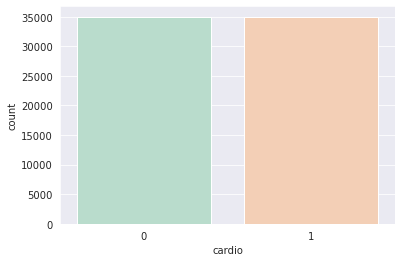

In [15]:
# Graficamente
sns.set_style("darkgrid")
sns.countplot(x = 'cardio', data = df, palette = 'Pastel2');

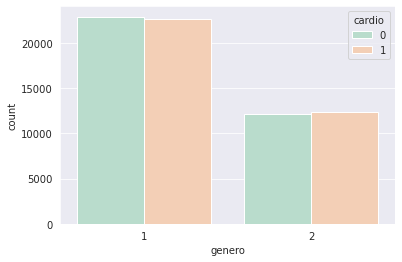

In [16]:
# Ocorrências por gênero

sns.countplot(x = 'genero', hue = 'cardio', data = df, palette = 'Pastel2');

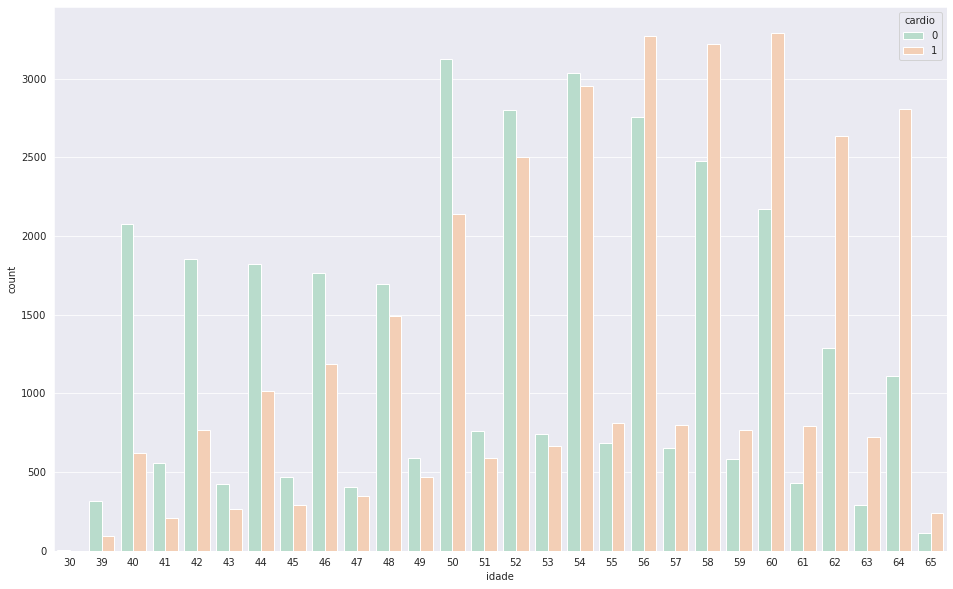

In [17]:
# Ocorrência por idade
plt.figure(figsize =[16, 10])
sns.countplot(x = 'idade', hue = 'cardio', data = df, palette = 'Pastel2');


Pode-se observar claramente uma maior tendência de doenças cardiovasculares a medida que a idade aumenta.
Observe que, a partir dos 55 anos, a barra que aponta a presença de doenças cardiovasculares(alaranjada) ultrapassa a de não ocorrência em todas as idades.

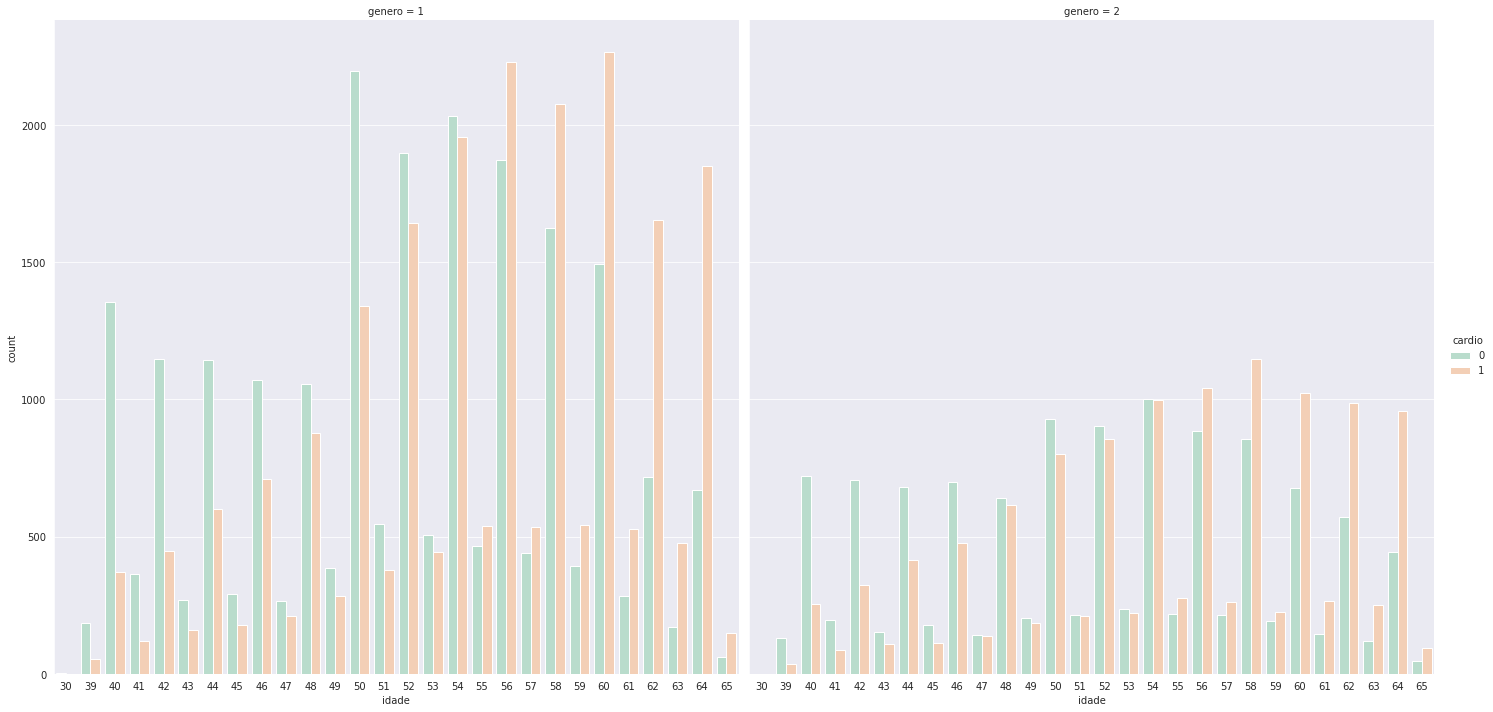

In [18]:
# Analisando as ocorrências por idade e por gênero.

sns.catplot(x = 'idade', hue = 'cardio', col = 'genero', kind = 'count', data = df, palette = 'Pastel2', height = 10);


A tendẽncia se observa tanto entre os homens como entre as mulheres, porém entre o sexo feminino o aumento é mais expressivo.

Vamos analisar agora as ocorrências sob outros aspectos.

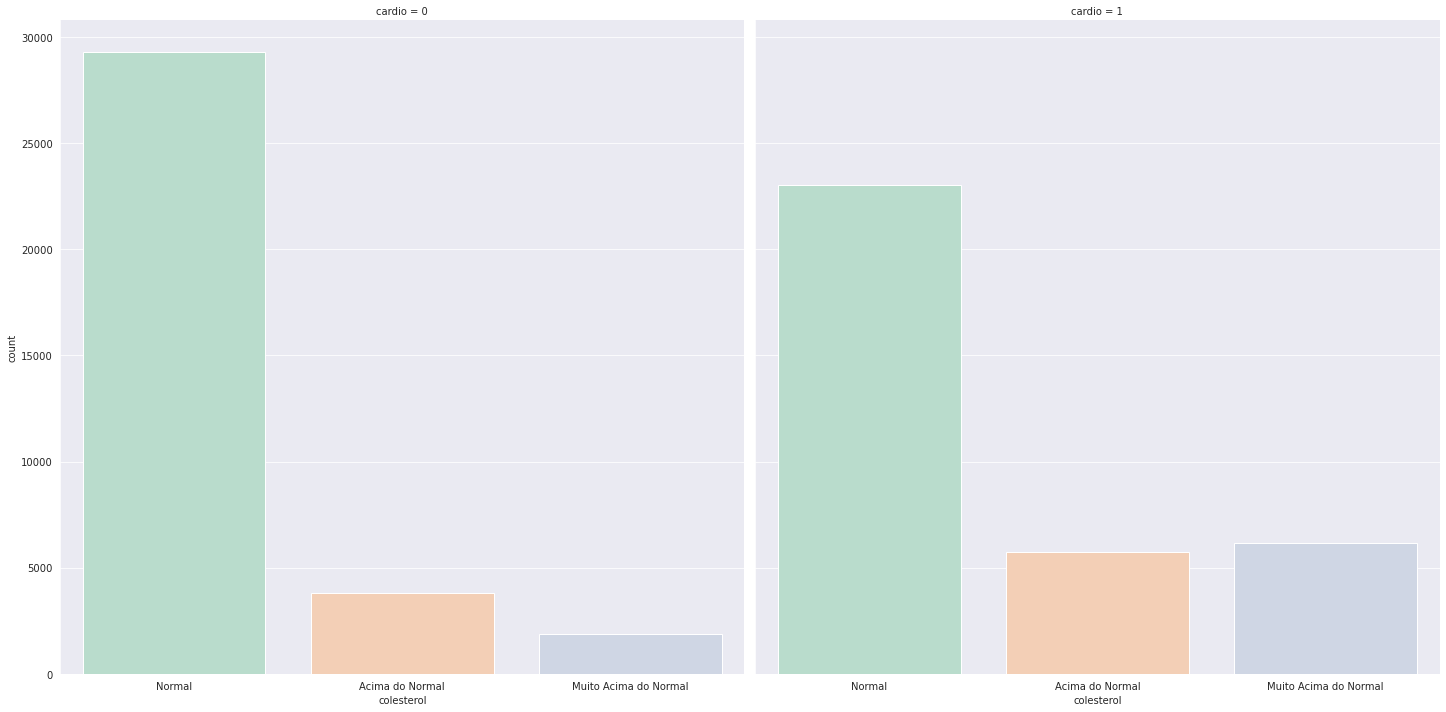

In [19]:
sns.catplot(x = 'colesterol', col = 'cardio', kind = 'count', data = df,
            palette = 'Pastel2',
            height = 10).set_xticklabels(['Normal', 'Acima do Normal', 'Muito Acima do Normal']);



Pelo gráfico acima fica claro que entre os pacientes que apresentam DCV, é mais frequente a presença de colesterol alto.

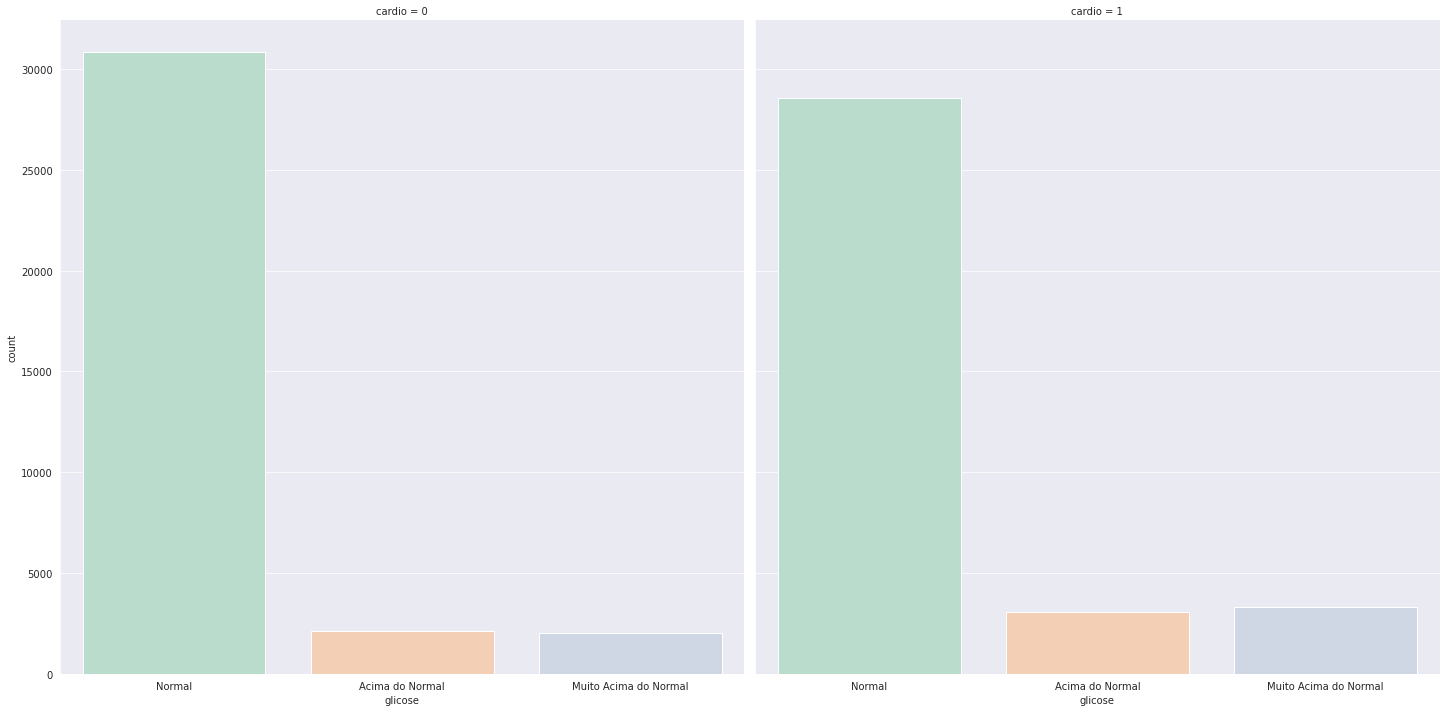

In [20]:
sns.catplot(x = 'glicose', col = 'cardio', kind = 'count', data = df,
            palette = 'Pastel2',
            height = 10).set_xticklabels(['Normal', 'Acima do Normal', 'Muito Acima do Normal']);

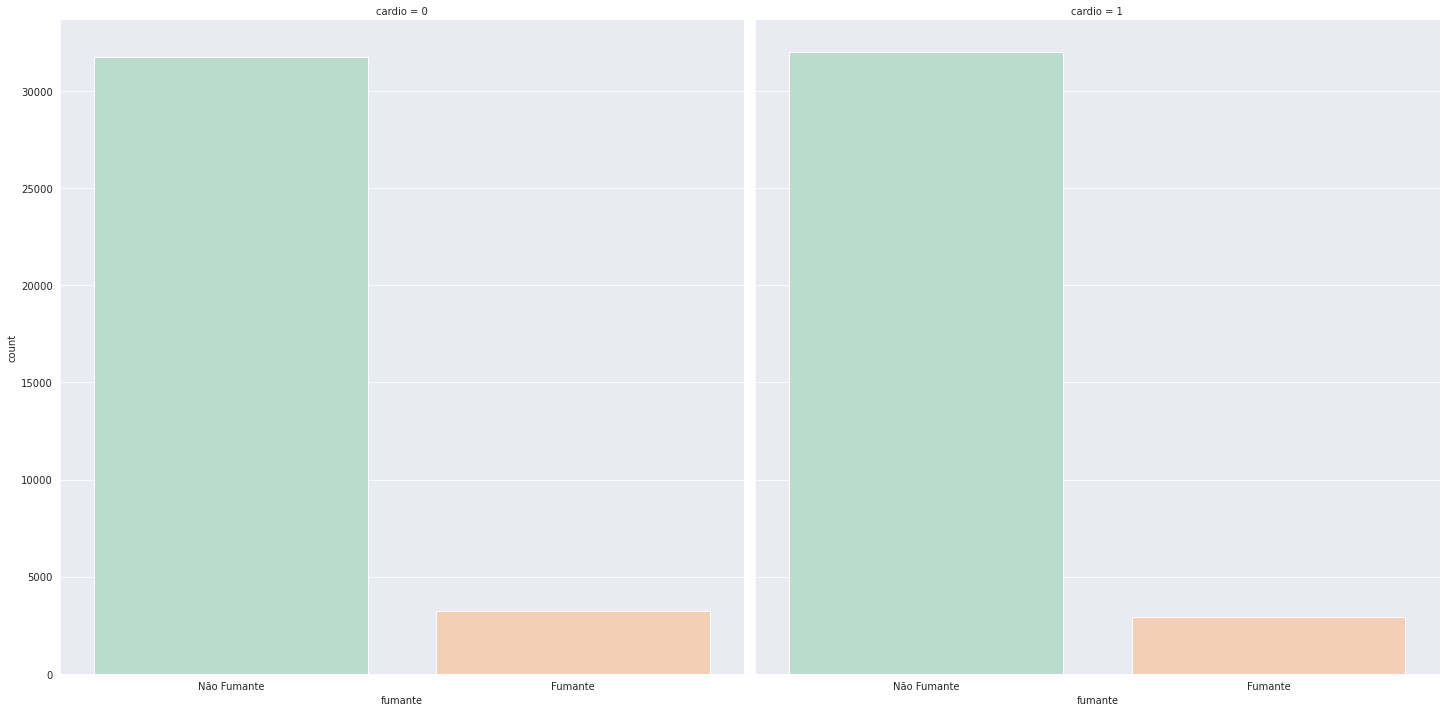

In [21]:
sns.catplot(x = 'fumante', col = 'cardio', kind = 'count', data = df,
            palette = 'Pastel2',
            height = 10).set_xticklabels(['Não Fumante', 'Fumante']);

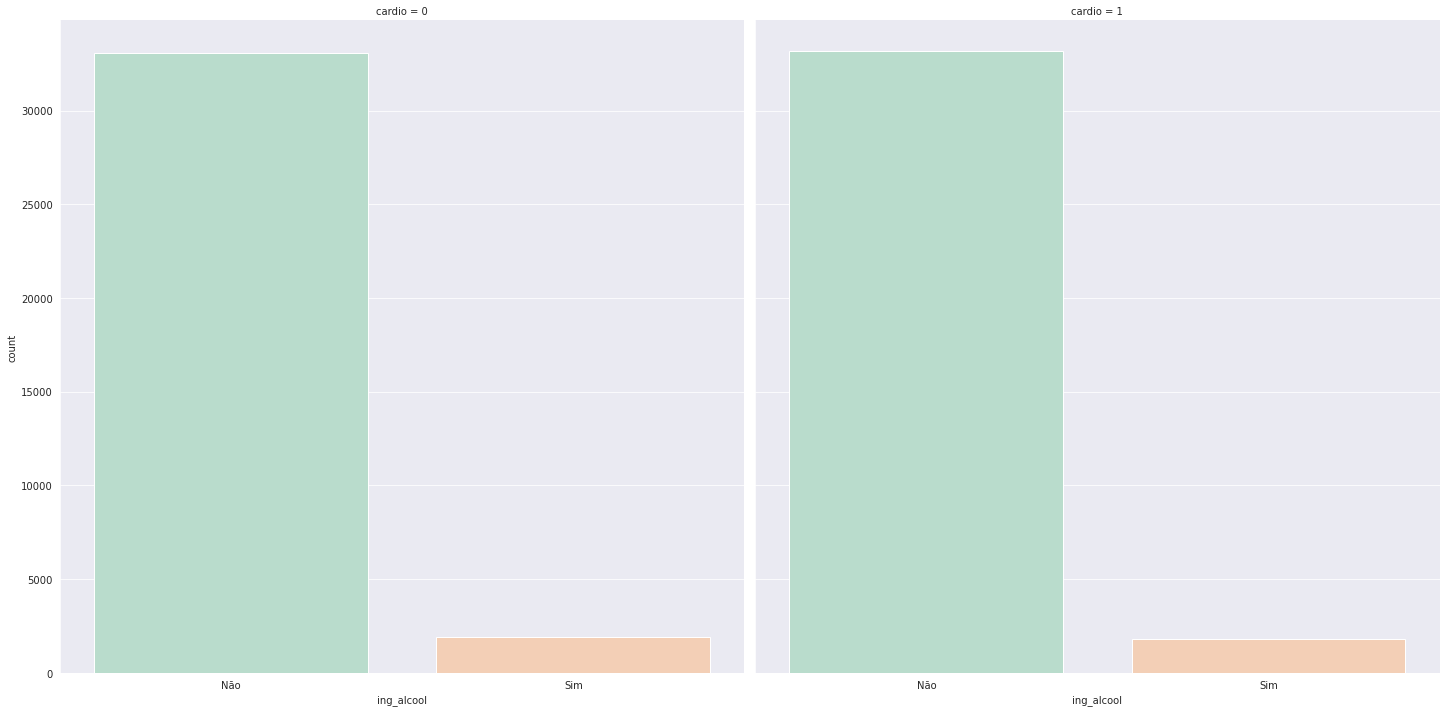

In [22]:
sns.catplot(x = 'ing_alcool', col = 'cardio', kind = 'count', data = df,
            palette = 'Pastel2',
            height = 10).set_xticklabels(['Não', 'Sim']);

Assim como no caso do colesterol, é possível ver uma relação entre a incidência de DCV e níveis elevados de glicose, o que não significa uma relação de causalidade.

Quanto a ser fumante ou ingerir bebidas alcoólicas, individualmente não é possível observar relação entre a ocorrência, pelo menos não expressivamente.

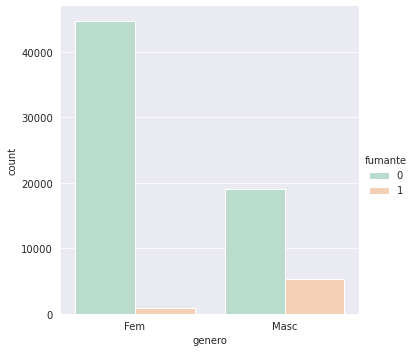

In [23]:
g = sns.catplot(x = 'genero', hue = 'fumante', kind = 'count', data = df, palette = 'Pastel2')
labels = ['Fem', 'Masc']
g.set_xticklabels(labels);



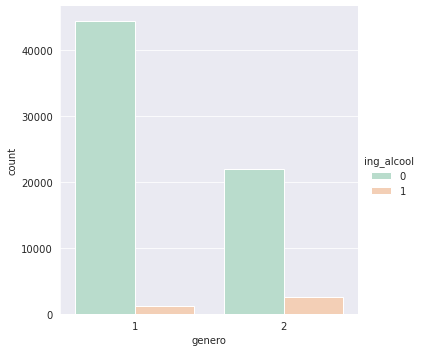

In [24]:
sns.catplot(x = 'genero', hue = 'ing_alcool', kind = 'count', data = df, palette = 'Pastel2')
labels = ['Fem', 'Masc']
g.set_xticklabels(labels);

Os homens são maioria entre os fumantes e ingestão de álcool.

## Limpando os dados

### Agora vamos voltar nas variáveis que apresentaram valores, para dizer o mínimo, estranhos.

Para que seja possível colocar mais de uma variável, vamos fazer uma fusão dos dados.

In [25]:
x_melt_pres = pd.melt(df, value_vars = ['pressao_sist', 'pressao_diast'], var_name = 'variaveis', value_name = 'valor')
x_melt_pres.head()

,variaveis,valor
0,pressao_sist,110
1,pressao_sist,140
2,pressao_sist,130
3,pressao_sist,150
4,pressao_sist,100


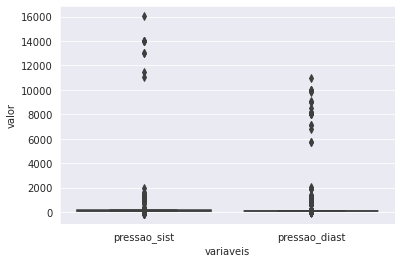

In [26]:
# Analisando a pressão
sns.boxplot(x = 'variaveis', y = 'valor', data = x_melt_pres);

#### Não é necessário ser um especialista na área médica para enxergar que, certamente, há erros nesses dados.
#### Basta uma pesquisa rápida para sabermos que alguns dos valores acima estão totalmente fora da realidade.

In [27]:
df.loc[:, ['pressao_sist', 'pressao_diast']].describe()

,pressao_sist,pressao_diast
count,69976.000000,69976.000000
mean,128.820453,96.636261
std,154.037729,188.504581
min,-150.000000,-70.000000
25%,120.000000,80.000000
50%,120.000000,80.000000
75%,140.000000,90.000000
max,16020.000000,11000.000000


In [28]:
df[(df['pressao_sist'] < 0) | (df['pressao_diast'] < 0)].count()

idade            8
genero           8
altura           8
peso             8
pressao_sist     8
pressao_diast    8
colesterol       8
glicose          8
fumante          8
ing_alcool       8
atividade_fis    8
cardio           8
dtype: int64

#### Aqui faremos a opão de excluir as observações em que tivermos valores negativos para a pressão arterial.

In [29]:
df.drop(df[(df['pressao_sist'] < 0) | (df['pressao_diast'] < 0)].index, inplace = True)

In [30]:
df.loc[:, ['pressao_sist', 'pressao_diast']].describe()

,pressao_sist,pressao_diast
count,69968.000000,69968.000000
mean,128.847044,96.640450
std,154.025612,188.514207
min,1.000000,0.000000
25%,120.000000,80.000000
50%,120.000000,80.000000
75%,140.000000,90.000000
max,16020.000000,11000.000000


#### Para tratar os valores extremos superiores, faremos a opção de substitui-los pela mediana, pois quando pegamos referências de valores para pressão, vemos que a mediana pode ser usada como uma boa medida, tanto para a pressão sistólica, como para a diastólica.
#### Considerarei outlier todo valor que estiver acima de 250 e abaixo de 80 para a sistólica, e maior que 200 e menor que 40 para a diastólica.

In [31]:
df.pressao_sist[(df['pressao_sist'] > 250) | (df['pressao_sist'] < 80)] = df['pressao_sist'].median()

In [32]:
df.pressao_diast[(df['pressao_diast'] > 200) | (df['pressao_diast'] < 40)] = df['pressao_diast'].median()

#### Por último iremos conferir se há algum observação em que a pressão diastólica é superior à sistólica



In [33]:
df[df['pressao_sist'] < df['pressao_diast']]

,idade,genero,altura,peso,pressao_sist,pressao_diast,colesterol,glicose,fumante,ing_alcool,atividade_fis,cardio
474,52,1,1.56,65.0,120,150,2,1,0,0,1,0
2384,64,1,1.54,102.0,90,150,1,1,0,0,0,1
2990,60,2,1.82,90.0,80,140,3,3,0,0,1,1
3447,55,2,1.80,80.0,80,125,3,3,1,1,1,1
3623,60,1,1.60,83.0,80,120,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
66315,62,1,1.69,88.0,120,160,3,3,0,0,0,1
66657,53,2,1.60,81.0,80,120,3,3,1,1,1,1
67421,64,1,1.53,74.0,80,130,1,1,0,0,1,1
67470,58,2,1.72,57.0,80,120,1,1,1,0,1,1


In [34]:
# Excluindo observações acima.

df.drop(df[df['pressao_sist'] < df['pressao_diast']].index, inplace = True)

#### Vamos olhar graficamente como ficaram nossas duas variáveis.

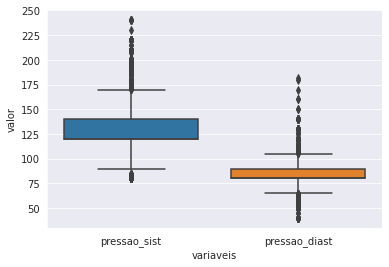

In [35]:
x_melt_pres = pd.melt(df, value_vars = ['pressao_sist', 'pressao_diast'], var_name = 'variaveis', value_name = 'valor')
sns.boxplot(x = 'variaveis', y = 'valor', data = x_melt_pres);

#### Agora iremos analisar e tratar as variáveis altura e peso.


In [36]:
# Ordenando os dados pela coluna altura e visualizando os 10 primeiros valores.
df.sort_values(by = 'altura').head(10)

,idade,genero,altura,peso,pressao_sist,pressao_diast,colesterol,glicose,fumante,ing_alcool,atividade_fis,cardio
22723,64,1,0.55,81.0,130,90,1,1,0,0,1,1
66643,52,1,0.57,61.0,130,90,1,1,0,0,1,1
64115,50,1,0.59,57.6,125,67,1,1,0,0,0,0
29157,52,1,0.60,69.0,110,70,1,1,0,0,0,0
27603,57,1,0.64,61.0,130,70,1,1,0,0,1,0
33607,54,2,0.65,72.0,130,80,1,1,0,0,0,0
44490,52,1,0.65,60.0,120,80,1,1,0,0,1,0
64454,58,1,0.66,63.0,120,80,1,1,0,0,0,1
50789,40,2,0.67,60.0,110,80,1,1,1,1,1,0
14323,60,1,0.67,57.0,120,90,1,1,0,0,1,1


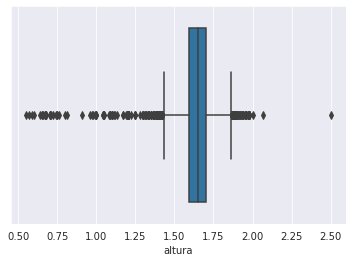

In [37]:
sns.boxplot(x = 'altura', data = df);

#### Olhando para os dados, podemos fazer algumas ponderações:
#### Ainda que tenhamos pessoas nos dados que sofram de nanismo, e por isso tenham idade adulta e pouca altura, é inimaginável que alguém nestas condições, com 55cm de altura, pese 81 Kg, o que nos sugere um erro de coleta.
#### Para tratar estes dados, usarei a média das alturas para substituir os valores. 
#### Porém, como sabemos que a média de altura entre homens e mulheres é diferente, vamos considerar isto na substituição.

In [38]:
df.altura[(df.altura < 1.40) & (df.genero == 1)] = 1.61
df.altura[(df.altura == 2.50) & (df.genero == 1)] = 1.61
df.altura[(df.altura < 1.40) & (df.genero == 2)] = 1.70

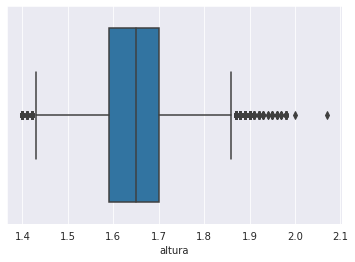

In [39]:
sns.boxplot(x = 'altura', data = df);

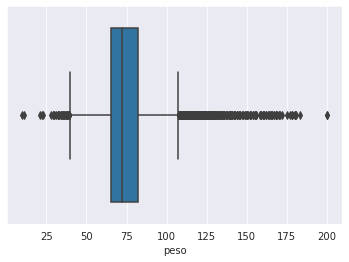

In [40]:
sns.boxplot(x = 'peso', data = df);

In [41]:
df.sort_values(by = 'peso').tail()

,idade,genero,altura,peso,pressao_sist,pressao_diast,colesterol,glicose,fumante,ing_alcool,atividade_fis,cardio
60592,52,2,1.80,180.0,140,100,3,1,0,0,1,1
36780,54,1,1.61,181.0,180,80,2,1,0,0,1,1
61285,57,2,1.80,183.0,110,80,3,3,0,1,1,1
435,46,1,1.86,200.0,130,70,1,1,0,0,0,0
50413,41,2,1.80,200.0,150,90,1,1,0,0,1,1


In [42]:
df.peso.describe()

count    69876.000000
mean        74.204309
std         14.397590
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: peso, dtype: float64

#### Para os outliers do peso fiz a escolha de excluir todos os dados que forem maiores que o percentil 99 e menor que o 1.

In [43]:
df.drop(df[(df['peso'] > df['peso'].quantile(0.99)) | (df['peso'] < df['peso'].quantile(0.01))].index, inplace = True)

In [44]:
# Verificando se, após a limpeza dos dados, foi gerado algum valor faltante.
df.isnull().any()

idade            False
genero           False
altura           False
peso             False
pressao_sist     False
pressao_diast    False
colesterol       False
glicose          False
fumante          False
ing_alcool       False
atividade_fis    False
cardio           False
dtype: bool

#### Seria interessante se tivéssemos alguma feature que pudesse classificar os pacientes pelo seu Indice de Massa Corporal, o IMC. Isso podemos resolver criando uma nova feature, pois temos todos os dados que precisamos para isso.

In [45]:
df['IMC'] = df['peso'] / (df['altura'] ** 2)

In [46]:
# Vamos conferir nossa nova feature

df['IMC'].describe()

count    68553.000000
mean        27.363923
std          4.818530
min         14.577259
25%         23.875115
50%         26.365603
75%         30.103806
max         58.024202
Name: IMC, dtype: float64

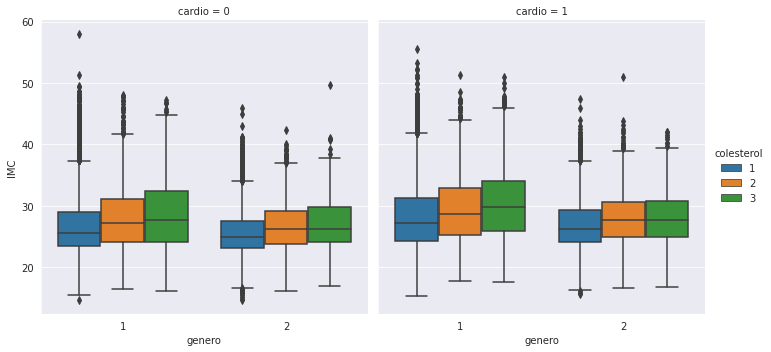

In [47]:
sns.catplot(x = 'genero', y = 'IMC', hue = 'colesterol', col = 'cardio', data = df, kind = 'box');

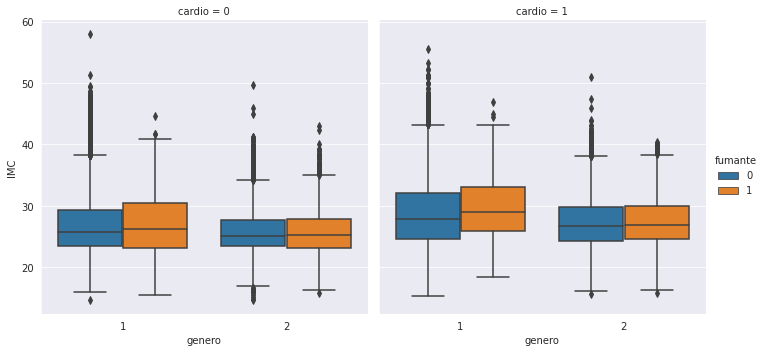

In [48]:
sns.catplot(x = 'genero', y = 'IMC', hue = 'fumante', col = 'cardio', data = df, kind = 'box');

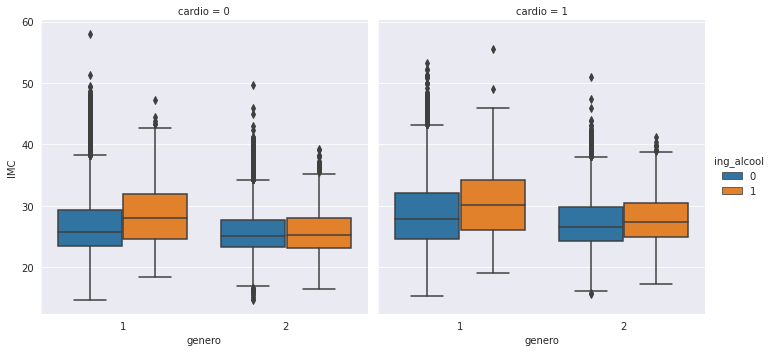

In [49]:
sns.catplot(x = 'genero', y = 'IMC', hue = 'ing_alcool', col = 'cardio', data = df, kind = 'box');

In [50]:
# Dimensões finais do nosso df
df.shape

(68553, 13)

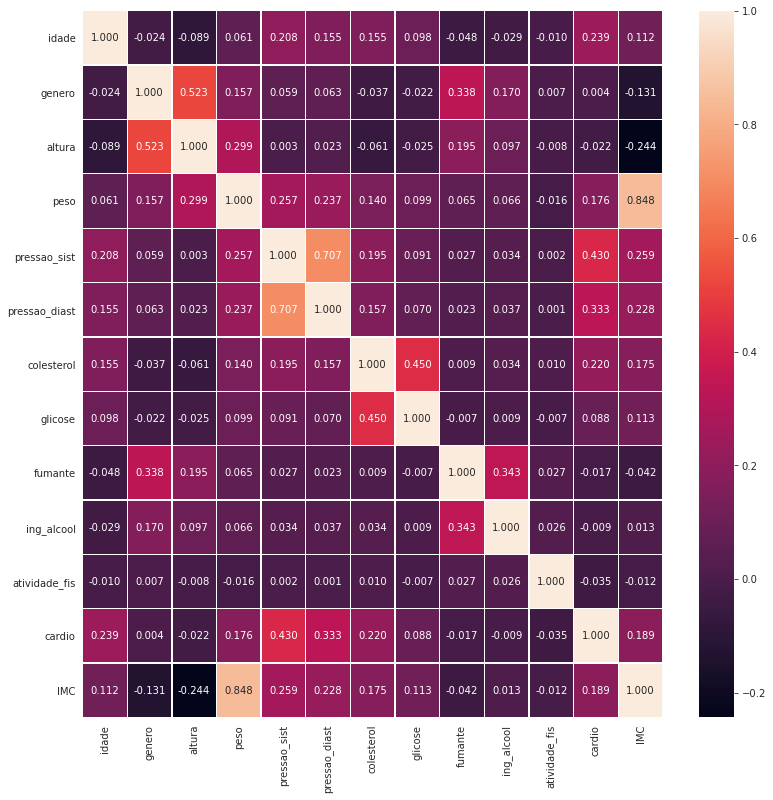

In [51]:
# Vamos ver a correlação entre as variáveis

corr = df.corr()

fig, ax = plt.subplots(figsize = (13, 13))
sns.heatmap(corr, annot = True, fmt = '.3f', linewidths = 0.3, ax = ax);

#### Podemos ver que as features com relação mais forte com a incidência de doenças cardiovasculares são: IMC, colesterol, pressao_sist, pressao_diast, peso e idade. Apesar de glicose não ter forte correlação, vale a pena ficar atento, pois ela tem uma forte relação com o colesterol, que por sua vez, possui relação com o cardio.

In [53]:
# Separando os dados entre variáveis dependentes e independentes.
df_y = df['cardio']
df_x = df
df_x.drop('cardio', axis = 1, inplace = True);
df_y.shape


(68553,)

In [54]:
df_x.head()

,idade,genero,altura,peso,pressao_sist,pressao_diast,colesterol,glicose,fumante,ing_alcool,atividade_fis,IMC
0,50,2,1.68,62.0,110,80,1,1,0,0,1,21.967120
1,55,1,1.56,85.0,140,90,3,1,0,0,1,34.927679
2,52,1,1.65,64.0,130,70,3,1,0,0,0,23.507805
3,48,2,1.69,82.0,150,100,1,1,0,0,1,28.710479
4,48,1,1.56,56.0,100,60,1,1,0,0,0,23.011177


#### Vamos separar nosso conjunto de dados em treino e teste, para então aplicar uma padronização.

In [55]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.30)

In [56]:
# Normalizando os dados com StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Modelagem

#### Primeiro farei um apanhado geral de 5 algoritmos de classificação para ter uma ideia inicial do seu desempenho, para então decidir em qual focar e tentar otimizar.

In [59]:
classificadores = {
    'Regressão Logística': LogisticRegression(),
    'Support Vector Machines': SVC(),
    'Árvore de Decisão': DecisionTreeClassifier(),
    'Floresta Randômica': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

resultado = pd.DataFrame(columns = ['Acurácia %', 'F1-score'])

for alg, func in classificadores.items():
    func.fit(x_train, y_train)
    previsao = func.predict(x_test)
    resultado.loc[alg] = [round((accuracy_score(y_test, previsao)*100), 3), round(f1_score(y_test, previsao), 3)]

In [83]:
resultado

,Acurácia %,F1-score
Regressão Logística,73.014,0.715
Support Vector Machines,73.719,0.722
Árvore de Decisão,63.819,0.634
Floresta Randômica,71.049,0.707
KNN,69.941,0.696


Vamos usar o algoritmo GridSearchCV para buscar os melhores parâmetros para a nossa Floresta Randômica

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
param_grid = {
    'n_estimators': [150, 300],
    'max_features': [3, 4],
    'min_samples_leaf': [1, 3],
}

grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5)
grid_rfc.fit(x_train, y_train)
grid_rfc.best_params_

{'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 300}

In [69]:
print('Melhor Score: {:.2f}'.format(grid_rfc.best_score_ * 100))

Melhor Score: 72.90


In [67]:
grid_rfc_prev = grid_rfc.predict(x_test)

In [79]:
print('Acurácia: {:.3f} | F1-Score: {:.3f}'.format(accuracy_score(y_test, grid_rfc_prev)* 100, f1_score(y_test, grid_rfc_prev)* 100))

Acurácia: 73.383 | F1-Score: 72.454


Tentando otimizar o modelo de Regressão Logística

In [82]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.10, 0.1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

grid_rl = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid_rl.fit(x_train, y_train)
grid_rl.best_params_
print('Melhor Score: {:.3f}'.format(grid_rl.best_score_ * 100))

Melhor Score: 72.745


In [84]:
grid_rl.best_params_

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [85]:
grid_rl_prev = grid_rl.predict(x_test)


In [86]:
print('Acurácia: {:.3f} | F1-Score: {:.3f}'.format(accuracy_score(y_test, grid_rl_prev)* 100, f1_score(y_test, grid_rl_prev)* 100))

Acurácia: 73.004 | F1-Score: 71.511


Utilizando o GridSearchCV foi possível otimizar o RandomForest de 71 para 73%, já o LogisticRegression não teve melhora significativa.
Ainda seria possível tentar fazer mais alguns ajustes, para tentarmos otimizar mais alguma coisa, mas foge o escopo deste projeto, então vamos parar por aqui.